In [111]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import xarray as xr
import pyproj as p
import datetime

In [112]:
def partitioning(np,ny):
    rem = ny%np
    
    
    partition_ny = []
    prefix_sum = []

    for idx in range(0,np):
        partition_ny.append(int((ny-rem)/np))
        if (idx < rem):
            partition_ny[idx] = int(partition_ny[idx] + 1)
    for ii in range(0,np):
        if ii == 0:
            prefix_sum.append(0)
        else:
            prefix_sum.append(int(partition_ny[ii-1] + prefix_sum[ii-1]))

    return prefix_sum, partition_ny

In [113]:
"""
    INPUTS
"""
WY = '2019'
WY_int = 2021

wrf_404_dict = {'num_proc': 500,
            ## wrf snowfrac 3 ##
            # 'global_ny': 12272,
            # 'global_nx': 16774,
                
            ## wrf snowfrac 4,5 ##
            'global_ny': 8781,
            'global_nx': 14969,
            'timestep' : 2919,
            'output_dir': f'/glade/scratch/rossamower/snow/snowmodel/washington/conus_404/discover_outputs/snowfrac_5/WY{WY}/binary/',
            ## wrf snowfrac 4,5 ##
            'domain_nc': '/glade/scratch/rossamower/snow/snowmodel/washington/conus_404/python/snowmodel/wash_wrf_ids_ctrl.nc',
                
            ## wrf snowfrac 3 ##
            # 'domain_nc': '/glade/scratch/rossamower/snow/snowmodel/washington/conus_404/python/snowmodel/wash_wrf_404_ctrl_2.nc',
            'toutput': 'daily',
            'tstart' : f'10/01/{str(WY_int-1)[:-2]} 03:00:00'}

nldas_dict = {'num_proc': 500,
            'global_ny': 8781,
            'global_nx': 14969,
            'timestep' : 2919,
            'output_dir': '/glade/scratch/rossamower/snow/snowmodel/washington/nldas/discover_outputs/binary/',
            'domain_nc': '/glade/scratch/rossamower/snow/snowmodel/washington/conus_404/python/snowmodel/wash_wrf_ids_ctrl.nc',
            'toutput': 'daily',
            'tstart' : '10/01/18 03:00:00'}

uw_wrf_dict = {'num_proc': 500,
            'global_ny': 8781,
            'global_nx': 14969,
            'timestep' : 2919,
            'output_dir': '/glade/scratch/rossamower/snow/snowmodel/washington/ids/discover_outputs/snowfrac_5/binary/',
            'domain_nc': '/glade/scratch/rossamower/snow/snowmodel/washington/conus_404/python/snowmodel/wash_wrf_ids_ctrl.nc',
            'toutput': 'daily',
            'tstart' : '10/01/18 03:00:00'}

# shapefile #
shp_fpath = '/glade/u/home/rossamower/work/github_postproc/Presentation/figures/snowmodel/shapefile/'
shp_file = 'cb_2018_us_state_20m.shp'
## load state boundaries ##
state_boundary = gpd.read_file(shp_fpath + shp_file)
country_boundary = gpd.read_file(shp_fpath + shp_file)
state_boundary = state_boundary.to_crs(epsg=4326)
country_boundary = country_boundary.to_crs(epsg=4326)
print(state_boundary.crs)
boundary_gpd = country_boundary[country_boundary['STUSPS'] == 'WA']

    

epsg:4326


In [114]:
"""
    DOMAIN DATASET
"""
ds_404_domain = xr.load_dataset(wrf_404_dict['domain_nc'])
ds_nldas_domain = xr.load_dataset(nldas_dict['domain_nc'])
ds_ids_domain = xr.load_dataset(uw_wrf_dict['domain_nc'])
ds_404_domain

<xarray.Dataset>
Dimensions:  (east_west: 14969, south_north: 8781)
Coordinates:
    XLAT     (south_north, east_west) float32 46.7 46.7 46.7 ... 49.09 49.09
    XLONG    (south_north, east_west) float32 -123.0 -123.0 ... -116.7 -116.7
Dimensions without coordinates: east_west, south_north
Data variables:
    HGT      (south_north, east_west) float32 69.27 69.13 ... 1.309e+03
    VEG      (south_north, east_west) float32 3.0 3.0 3.0 3.0 ... 1.0 1.0 1.0

In [115]:
elev = float(ds_404_domain.HGT[12,2].values)
elev

56.619873046875

In [116]:
# fig,ax = plt.subplots()
# plt.pcolormesh(ds_404_domain.XLONG,ds_404_domain.XLAT,ds_404_domain.HGT)


# fig,ax = plt.subplots()
# plt.pcolormesh(ds_nldas_domain.XLONG,ds_nldas_domain.XLAT,ds_nldas_domain.HGT)

In [117]:
def index_array(var,inputs_dict,proc,partition_,prefix_,lat_index,long_index):
    # create 1D array #
    arry_1D =  np.fromfile(inputs_dict['output_dir']+ var + '_' + str(proc) + '.gdat', dtype=np.float32)
    # total time #
    tot_t = int(arry_1D.shape[0]/(partition_[proc]*inputs_dict['global_nx']))
    # create 3D array #
    arry_3D = arry_1D.reshape(tot_t,partition_[proc],inputs_dict['global_nx'])
    # index array #
    index_array = arry_3D[:,lat_index - prefix_[proc],long_index]
    
    return index_array
    
    
    

In [118]:
def create_datetime(start,tstep,tot_time):
    
    if tstep == 'daily':
        date_time_obj = datetime.datetime.strptime(start, '%m/%d/%y %H:%M:%S')
        date_obj = date_time_obj.date()
        date_final = date_obj + datetime.timedelta(days=1)

        datet = pd.date_range(start = date_final,periods = 364,freq = '1D')
        datet_np = datet.to_numpy()
    else:
        datet = pd.date_range(start = start,periods = 364,freq = '3H')
        datet_np = datet.to_numpy()
    return datet_np
    
    

In [119]:
def snotel_statistics(ds_snotel,ds_snowmodel,var):
    # try:
    # RMSE #
    rmse = float(((((ds_snotel[var][1:-30] - ds_snowmodel[var])**2).sum(skipna = True))/ds_snowmodel[var].shape[0])**0.5)
    #AVG DIFF #
    avgdiff = float(((ds_snotel[var][1:-30] - ds_snowmodel[var])).mean(skipna = True))
    # L INFIN NORM #
    lnorm = float((abs(ds_snotel[var][1:-30] - ds_snowmodel[var])).max(skipna = True))
    # except:
        # print('COULD NOT PROCESS STATISTICS FOR '+ var)
    
    return rmse,avgdiff,lnorm

In [120]:
def create_xarray(swe,snod,t_,xlat,xlon,snotel_name,outputdir,ds_snotel):
    
    lat = np.array([xlat])
    lon = np.array([xlon])
    
    # create xarray and clip to the beginning of september [ie 9/1/2019]
    
    ds = xr.Dataset(
                data_vars = dict(
                    SWED = (["Time"],swe[:-30]),
                    SNOD = (["Time"],snod[:-30]),
                ),
                coords={"Time": ("Time",t_[:-30]),
                        "XLAT": (("south_north"),lat),
                        "XLONG": (("east_west"),lon),})

    ds['SWED']['units'] = 'meters'
    ds['SWED']['standard_name'] = 'snow water equivalent'
    ds['SNOD']['units'] = 'meters'
    ds['SNOD']['standard_name'] = 'snow depth'
    
    
    # ds['Time'] = pd.DatetimeIndex(ds['Time'].values)
    
    # ds.to_netcdf(outputdir + snotel_name,
    #                     encoding = {"Time":
    #                                     {'dtype' : 'float64',
    #                                      'units' : 'hours since 1901-01-01 00:00:00',
    #                                      'calendar' : 'standard'}})
    # generate swed statistics #
    swed_rmse,swed_avgdiff,swed_lnorm = snotel_statistics(ds_snotel,ds,'SWED')
    # generate snod statistics #
    snod_rmse,snod_avgdiff,snod_lnorm = snotel_statistics(ds_snotel,ds,'SNOD')
    
    # nldas_swed_rmse,wrf_swed_rmse,nldas_swed_avgdiff,wrf_swed_avgdiff,nldas_swed_lnorm,wrf_swed_lnorm,ids_swed_rmse,ids_swed_avgdiff,ids_swed_lnorm = snotel_statistics(ds_snotel,ds,'SWED')
    # # generate snod statistics #
    # nldas_snod_rmse,wrf_snod_rmse,nldas_snod_avgdiff,wrf_snod_avgdiff,nldas_snod_lnorm,wrf_snod_lnorm,ids_snod_rmse,ids_snod_avgdiff,ids_snod_lnorm = snotel_statistics(ds_snotel,ds,'SNOD')
    
    
    return swed_rmse,snod_rmse,swed_avgdiff,snod_avgdiff,swed_lnorm,snod_lnorm,ds
    
    

In [121]:
def distance_index(lat_2d,lon_2d,lat_,lon_,shape_):
    
    distance_to_location =  (lat_2d-lat_)**2 + (lon_2d-lon_)**2
    [lat_ind,lon_ind] = np.unravel_index( np.argmin(distance_to_location), shape_)
    return lat_ind,lon_ind

In [122]:
def create_array(input_dict,lat_idx,lon_idx):
    pref_s, part_ny = partitioning(input_dict['num_proc'],input_dict['global_ny'])
    
    count = 0
    for pref in pref_s:
        if pref < lat_idx:
            count += 1
    processor = count - 1
    
    # pull data #
    var1 = 'swed'
    var2 = 'snod' # CHANGE TO SNOD
    
    arr_1 = index_array(var1,input_dict,processor,part_ny,pref_s,lat_idx,lon_idx)
    arr_2 = index_array(var2,input_dict,processor,part_ny,pref_s,lat_idx,lon_idx)
    
    
    return arr_1,arr_2

In [123]:
def sm_snotel_intersect(fname_snotel,lat_arr,lon_arr,inputs,
                        output_dir,shape,t_arr):
    
    # pull snotel data #
    snotel_dir = f'snotel/data/WY{WY}/'
    ds_1 = xr.load_dataset(snotel_dir + fname_snotel)
    
    # identify snotel lat and lon #
    lat = ds_1.XLAT[0].values
    lon = ds_1.XLONG[0].values
    
    
    # identify index of station #
    lat_idx, lon_idx = distance_index(lat_arr,lon_arr,lat,lon,shape)
    
    
    
    # identify processor and local indexes #
    swed,snod = create_array(inputs,lat_idx,lon_idx)
    
    # generate netcdf and return statistics
    swed_rmse,snod_rmse,swed_avgdiff,snod_avgdiff,swed_lnorm,snod_lnorm,ds= create_xarray(swed,snod,t_arr,lat,lon,fname_snotel,output_dir,ds_1)
    # wrf_swed_lnorm,ids_swed_rmse,ids_swed_avgdiff,ids_swed_lnorm,ids_snod_rmse,ids_snod_avgdiff,ids_snod_lnorm = create_xarray(wrf_swed,wrf_snod,nldas_swed,nldas_snod,ids_swed,ids_snod,t_arr,lat,lon,fname_snotel,output_dir,ds_1)
    
    return lat_idx,lon_idx,swed_rmse,snod_rmse,swed_avgdiff,snod_avgdiff,swed_lnorm,snod_lnorm,lat,lon,ds,ds_1
    
    

In [124]:
def concat_datasets(ds_wrf,ds_ids,ds_nldas,snotel,outputdir,snotel_name):
    # snotel #
    snotel_swe = snotel.SWED[1:-30].values
    snotel_snod = snotel.SNOD[1:-30].values
    time = snotel.Time[1:-30].values
    lat = snotel.XLAT.values
    lon = snotel.XLONG.values
    # wrf #
    wrf_swe = ds_wrf.SWED.values
    wrf_snod = ds_wrf.SNOD.values
    
    # nldas #
    nldas_swe = ds_nldas.SWED.values
    nldas_snod = ds_nldas.SNOD.values
    
    # ids #
    ids_swe = ds_ids.SWED.values
    ids_snod = ds_ids.SNOD.values
    
    # concat #
    ds = xr.Dataset(
                data_vars = dict(
                    snotel_swe = (["Time"],snotel_swe),
                    snotel_snod = (["Time"],snotel_snod),
                    nldas_swe = (["Time"],nldas_swe),
                    nldas_snod = (["Time"],nldas_snod),
                    conus_swe = (["Time"],wrf_swe),
                    conus_snod = (["Time"],wrf_snod),
                    uw_swe = (["Time"],ids_swe),
                    uw_snod = (["Time"],ids_snod),
                ),
                coords={"Time": ("Time",time),
                        "XLAT": (("south_north"),lat),
                        "XLONG": (("east_west"),lon),})
    # ds.to_netcdf(outputdir + snotel_name,
    #                     encoding = {"Time":
    #                                     {'dtype' : 'float64',
    #                                      'units' : 'hours since 1901-01-01 00:00:00',
    #                                      'calendar' : 'standard'}})
    return ds



In [125]:

def snow_onset_dates(ds):
    
    ## date max snowpack ##
    t_max = np.where(ds.SNOD == ds.SNOD.max(skipna = True).values)[0][0]
    # t_max = np.where(ds.SNOD == ds.SNOD.values.max())[0][0]
    t_max_dt = ds.Time[t_max].values
    
    ## date snowoff ##
    snod_ = ds.SNOD.values
    ## find first value after max where snow is less than 0.0005 ##
    t = t_max
    flag = True
    while flag == True:
        if snod_[t] < 0.0005:
            flag = False
            t_off = t
        if (t == len(snod_) - 1):
            flag = False
            t_off = t
        t += 1
    t_off_dt = ds.Time[t_off].values
    
    t = t_max
    flag = True
    while flag == True:
        if snod_[t] < 0.0005:
            flag = False
            t_on = t
        if t == 0:
            flag = False
            t_on = t
        t -= 1
    t_on_dt = ds.Time[t_on].values
    
        
    
    return t_max,t_max_dt,t_off,t_off_dt,t_on,t_on_dt

# def snow_onset_dates(ds):
    
    
#     ## date snowoff ##
#     snod_ = ds.SNOD.values
#     ## find first value after max where snow is less than 0.0005 ##
#     t = 0
#     flag = True
#     while flag == True:
#         if snod_[t] > 0.01:
#             if snod_[t+2] > 0.01:
#                 flag = False
#                 t_off = t
#         t += 1
#     t_off_dt = ds.Time[t_off].values
    
        
    
#     return t_off,t_off_dt
    

    

In [126]:
# import os
# import time
# from IPython.display import clear_output

# # output directory #
# output_direc = 'snowmodel/snotel2/'
# snotel_dir = f'snotel/data/WY{2019}/'

# files = os.listdir(snotel_dir)

# # wrf domain #
# lat_domain_wrf=ds_404_domain.XLAT.values
# lon_domain_wrf=ds_404_domain.XLONG.values


# # ids domain #
# lat_domain_ids=ds_ids_domain.XLAT.values
# lon_domain_ids=ds_ids_domain.XLONG.values

# # nldas domain #
# lat_domain_nldas=ds_nldas_domain.XLAT.values
# lon_domain_nldas=ds_nldas_domain.XLONG.values

# # create timing #
# t_ar = create_datetime(wrf_404_dict['tstart'],wrf_404_dict['toutput'],wrf_404_dict['timestep'])


# missing_data = []

# df_nldas = pd.DataFrame(columns=['snotel','latitude','longitude', 'elevation', 'vegetation','swe_avg_diff','swe_rmse','swe_l_inf_norm'])
# df_wrf = pd.DataFrame(columns=['snotel', 'latitude','longitude','elevation', 'vegetation','swe_avg_diff','swe_rmse','swe_l_inf_norm'])
# df_ids = pd.DataFrame(columns=['snotel', 'latitude','longitude','elevation', 'vegetation','swe_avg_diff','swe_rmse','swe_l_inf_norm'])

# snotel_lat = []
# snotel_lon = []
# snotel_name = []
# nldas_swed = []
# nldas_snod = []
# wrf_swed = []
# wrf_snod = []
# ids_swed = []
# ids_snod = []

# count = 0
# for f in files:
#     f = 'Quartz_Peak.nc'
#     print(f)

#     # ty:
#     # if f in ['Muckamuck.nc']:
#     # wrf #
#     wrf_idx,wrf_idy,wrf_swed_rmse,wrf_snod_rmse,wrf_swed_avgdiff,wrf_snod_avgdiff,wrf_swed_lnorm,wrf_snod_lnorm,lat,lon,ds_wrf,snotel = sm_snotel_intersect(f,
#                          lat_domain_wrf,lon_domain_wrf,wrf_404_dict,
#                          output_direc,ds_404_domain.XLAT.shape,t_ar)
#     wrf_maxsnow_idx,wrf_maxsnow_dt, wrf_snowoff_idx,wrf_snowoff_dt,wrf_firstsnow_idx,wrf_firstsnow_dt = snow_onset_dates(ds_wrf)
#     # wrf_firstsnow_idx,wrf_firstsnow_dt = snow_onset_dates(ds_wrf)
    
#     # ids #
#     ids_idx,ids_idy,ids_swed_rmse,ids_snod_rmse,ids_swed_avgdiff,ids_snod_avgdiff,ids_swed_lnorm,ids_snod_lnorm,lat,lon,ds_ids,snotel = sm_snotel_intersect(f,
#                  lat_domain_ids,lon_domain_ids,uw_wrf_dict,
#                  output_direc,ds_ids_domain.XLAT.shape,t_ar)
#     ids_maxsnow_idx,ids_maxsnow_dt, ids_snowoff_idx,ids_snowoff_dt,ids_firstsnow_idx,ids_firstsnow_dt = snow_onset_dates(ds_ids)
#     # ids_firstsnow_idx,ids_firstsnow_dt = snow_onset_dates(ds_ids)
    
#     # nldas #
#     nldas_idx,nldas_idy,nldas_swed_rmse,nldas_snod_rmse,nldas_swed_avgdiff,nldas_snod_avgdiff,nldas_swed_lnorm,nldas_snod_lnorm,lat,lon,ds_nldas,snotel = sm_snotel_intersect(f,
#          lat_domain_nldas,lon_domain_nldas,nldas_dict,
#          output_direc,ds_nldas_domain.XLAT.shape,t_ar)
    
#     nldas_maxsnow_idx,nldas_maxsnow_dt, nldas_snowoff_idx,nldas_snowoff_dt,nldas_firstsnow_idx,nldas_firstsnow_dt = snow_onset_dates(ds_nldas)
#     # nldas_firstsnow_idx,nldas_firstsnow_dt = snow_onset_dates(ds_nldas)
    
#     ## snotel ##
#     snotel_maxsnow_idx,snotel_maxsnow_dt, snotel_snowoff_idx,snotel_snowoff_dt,snotel_firstsnow_idx,snotel_firstsnow_dt = snow_onset_dates(snotel)
#     # snotel_firstsnow_idx,snotel_firstsnow_dt = snow_onset_dates(snotel)
    
    
#     snotel_lat.append(lat)
#     snotel_lon.append(lon)
#     snotel_name.append(f[:-3])
    
#     del_ = 10
    
    
#     # ds concat #
#     ds_concat = concat_datasets(ds_wrf,ds_ids,ds_nldas,snotel,output_direc,f)
    
#     # peak wrf #
#     wrf_peak_swe = ds_concat.conus_swe.values.max()
#     wrf_peak_snod = ds_concat.conus_snod.values.max()
#     # peak wrf #
#     nldas_peak_swe = ds_concat.nldas_swe.values.max()
#     nldas_peak_snod = ds_concat.nldas_snod.values.max()
#     # peak snotel #
#     snotel_peak_swe = ds_concat.snotel_swe.values.max()
#     snotel_peak_snod = ds_concat.snotel_snod.values.max()
    
#     # percent_diff #
#     percent_diff_swe_wrf = (snotel_peak_swe - wrf_peak_swe) / snotel_peak_swe
#     percent_diff_snod_wrf = (snotel_peak_snod - wrf_peak_snod) / snotel_peak_snod
#     # percent_diff #
#     percent_diff_swe_nldas = (snotel_peak_swe - nldas_peak_swe) / snotel_peak_swe
#     percent_diff_snod_nldas = (snotel_peak_snod - nldas_peak_snod) / snotel_peak_snod
        
#     fig,ax = plt.subplots(1,2,figsize = (10,5))
#     ax[0].plot(ds_concat.Time,ds_concat.conus_snod,label = 'WRF 404',color = 'blue')
#     # ax[0].plot(ds_concat.Time,ds_concat.uw_snod,label = 'IDS',color = 'red')
#     ax[0].plot(ds_concat.Time,ds_concat.nldas_snod,label = 'NLDAS2',color = 'orange')
#     ax[0].plot(ds_concat.Time,ds_concat.snotel_snod,'k-.',label = 'Snotel')
#     ax[0].legend()
#     ax[0].set_ylabel('SNOD[m]')
#     ax[0].tick_params(axis='x', rotation=45)
#     ax[0].set_title(f[:-3] + ' SNOD')

#     ax[1].plot(ds_concat.Time,ds_concat.conus_swe,label = 'WRF 404',color = 'blue')
#     # ax[1].plot(ds_concat.Time,ds_concat.uw_swe,label = 'IDS',color = 'red')
#     ax[1].plot(ds_concat.Time,ds_concat.nldas_swe,label = 'NLDAS2',color = 'orange')
#     ax[1].plot(ds_concat.Time,ds_concat.snotel_swe,'k-.',label = 'Snotel')
#     ax[1].legend()
#     ax[1].set_ylabel('SWE[m]')
#     ax[1].tick_params(axis='x', rotation=45)
#     ax[1].set_title(f[:-3] + ' SWE')
#     plt.show()
#     if wrf_firstsnow_idx < snotel_firstsnow_idx:
#         min_ = wrf_firstsnow_idx - del_
#         if min_ < 0:
#             min_ = min_ + del_
#         max_ = snotel_firstsnow_idx + del_
#     else:
#         min_ = snotel_firstsnow_idx - del_
#         if min_ < 0:
#             min_ = min_ + del_
#         max_ = wrf_firstsnow_idx + del_
#     fig,ax = plt.subplots(1,2,figsize = (10,5))
#     ax[0].plot(ds_concat.Time[min_:max_],ds_concat.conus_snod[min_:max_],label = 'WRF 404',color = 'blue')
#     ax[0].plot(ds_concat.Time[min_:max_],ds_concat.snotel_snod[min_:max_],'k-.',label = 'Snotel')
#     ax[0].scatter(ds_concat.Time[snotel_firstsnow_idx],ds_concat.snotel_snod[snotel_firstsnow_idx],color = 'black',label = 'Snotel')
#     ax[0].scatter(ds_concat.Time[wrf_firstsnow_idx+1],ds_concat.conus_snod[wrf_firstsnow_idx+1],color = 'blue',label = 'WRF 404')
#     ax[0].legend()
#     ax[0].set_ylabel('SNOD[m]')
#     ax[0].tick_params(axis='x', rotation=45)
#     ax[0].set_title(f[:-3] + ' First date of continuous snow')
#     if wrf_snowoff_idx < snotel_snowoff_idx:
#         min_ = wrf_snowoff_idx - del_
#         max_ = snotel_snowoff_idx + del_
#         max_var = 'SNOTEL'
#     else:
#         min_ = snotel_snowoff_idx - del_
#         max_ = wrf_snowoff_idx + del_
#         max_var = 'WRF 404'
#     ax[1].plot(ds_concat.Time[min_:max_],ds_concat.conus_snod[min_:max_],label = 'WRF 404',color = 'blue')
#     ax[1].plot(ds_concat.Time[min_:max_],ds_concat.snotel_snod[min_:max_],'k-.',label = 'Snotel')
#     ax[1].scatter(ds_concat.Time[snotel_snowoff_idx],ds_concat.snotel_snod[snotel_snowoff_idx],color = 'black',label = 'Snotel')
#     ax[1].scatter(ds_concat.Time[wrf_snowoff_idx],ds_concat.conus_snod[wrf_snowoff_idx],color = 'blue',label = 'WRF 404')
#     ax[1].legend()
#     ax[1].set_ylabel('SNOD[m]')
#     ax[1].tick_params(axis='x', rotation=45)
#     ax[1].set_title(f[:-3] + ' Last date of continuous snow')
#     plt.show()
#     # identify elevation and vegetation of snotel #
#     elev = float(ds_nldas_domain.HGT[nldas_idx,nldas_idy].values)
#     veg = int(ds_nldas_domain.VEG[nldas_idx,nldas_idy].values)
#     nldas_dict_ = {'snotel':f[:-3], 'elevation':elev,'latitude':lat,'longitude':lon, 'vegetation':veg,'modelmax[SWE]':nldas_peak_swe,'snotelmax[SWE]':snotel_peak_swe,'snotel-model[SWE]':snotel_peak_swe-nldas_peak_swe,'% diff[SWE]':percent_diff_swe_nldas,
#                    'modelmax[SNOD]':nldas_peak_snod,'snotelmax[SNOD]':snotel_peak_snod,'snotel-model[SNOD]':snotel_peak_snod-nldas_peak_snod,'% diff[SNOD]':percent_diff_snod_nldas,
#                    'swe_avg_diff':(-1*nldas_swed_avgdiff),'swe_rmse':nldas_swed_rmse,'swe_l_inf_norm':nldas_swed_lnorm,
#                   'snod_avg_diff':(-1*nldas_snod_avgdiff),'snod_rmse':nldas_snod_rmse,'snod_l_inf_norm':nldas_snod_lnorm,
#                'first_snod_dt':pd.to_datetime(nldas_firstsnow_dt),'first_snod_diff': int(snotel_firstsnow_idx-nldas_firstsnow_idx+1),
#               'max_snod_dt':pd.to_datetime(nldas_maxsnow_dt),'max_snod_diff':int(snotel_maxsnow_idx-nldas_maxsnow_idx),
#                   'snowoff_snod_dt':pd.to_datetime(nldas_snowoff_dt),'snowoff_snod_diff':int(snotel_snowoff_idx-nldas_snowoff_idx)}
    
#     wrf_dict_ = {'snotel':f[:-3], 'elevation':elev,'latitude':lat,'longitude':lon, 'vegetation':veg,'modelmax[SWE]':wrf_peak_swe,'snotelmax[SWE]':snotel_peak_swe,'snotel-model[SWE]':snotel_peak_swe-wrf_peak_swe,'% diff[SWE]':percent_diff_swe_wrf,
#                    'modelmax[SNOD]':wrf_peak_snod,'snotelmax[SNOD]':snotel_peak_snod,'snotel-model[SNOD]':snotel_peak_snod-wrf_peak_snod,'% diff[SNOD]':percent_diff_snod_wrf,
#                  'swe_avg_diff':(-1*wrf_swed_avgdiff),'swe_rmse':wrf_swed_rmse,'swe_l_inf_norm':wrf_swed_lnorm,
#                 'snod_avg_diff':(-1*wrf_snod_avgdiff),'snod_rmse':wrf_snod_rmse,'snod_l_inf_norm':wrf_snod_lnorm,
#                  'first_snod_dt':pd.to_datetime(wrf_firstsnow_dt),'first_snod_diff':int(snotel_firstsnow_idx-wrf_firstsnow_idx+1),
#                   'max_snod_dt':pd.to_datetime(wrf_maxsnow_dt),'max_snod_diff':int(snotel_maxsnow_idx-wrf_maxsnow_idx),
#               'snowoff_snod_dt':pd.to_datetime(wrf_snowoff_dt),'snowoff_snod_diff':int(snotel_snowoff_idx-wrf_snowoff_idx)}
    
#     ids_dict_ = {'snotel':f[:-3], 'elevation':elev,'latitude':lat,'longitude':lon, 'vegetation':veg,
#                  'swe_avg_diff':(-1*ids_swed_avgdiff),'swe_rmse':ids_swed_rmse,'swe_l_inf_norm':ids_swed_lnorm,
#                  'snod_avg_diff':(-1*ids_snod_avgdiff),'snod_rmse':ids_snod_rmse,'snod_l_inf_norm':ids_snod_lnorm,
#                  'first_snod_dt':pd.to_datetime(ids_firstsnow_dt),'first_snod_diff':int(snotel_firstsnow_idx-ids_firstsnow_idx+1),
#                   'max_snod_dt':pd.to_datetime(ids_maxsnow_dt),'max_snod_diff':int(snotel_maxsnow_idx-ids_maxsnow_idx),
#                   'snowoff_snod_dt':pd.to_datetime(ids_snowoff_dt),'snowoff_snod_diff':int(snotel_snowoff_idx-ids_snowoff_idx)}
        
#     #          # append rows #
#     df_nldas = df_nldas.append(nldas_dict_, ignore_index = True)
#     df_wrf = df_wrf.append(wrf_dict_, ignore_index = True)
#     df_ids = df_ids.append(ids_dict_, ignore_index = True)
    
#     # time.sleep(5)
#     # # break
#     # # input('')
#     # clear_output(wait=True)
#     break
#     count += 1
            
                
#     # except:
#     print('Could not process '+ f)
#     missing_data.append(f)
            
            
            
#     count += 1
    
        
    
    
    
#     # sm_snotel_intersect(f,fname_sm_grid,wrf_404_inputs,output_dir)

In [127]:
float(ds_concat.snotel_swe.max(skipna = True).values)

0.5435599999999999

In [128]:
ds = xr.load_dataset('snotel/data/WY2021/Quartz_Peak.nc')
ds

<xarray.Dataset>
Dimensions:  (Time: 365, east_west: 1, south_north: 1)
Coordinates:
  * Time     (Time) datetime64[ns] 2020-10-01 2020-10-02 ... 2021-09-30
    XLAT     (south_north) float64 47.88
    XLONG    (east_west) float64 -117.1
Dimensions without coordinates: east_west, south_north
Data variables:
    SWED     (Time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    SNOD     (Time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [129]:
t = np.where(ds.SNOD == ds.SNOD.max(skipna = True).values)[0][0]

In [130]:
ds.SWED[t].values

array(0.5334)

In [131]:
ds.SNOD[t].values

array(1.6764)

In [132]:
# wrf_idx,wrf_idy,wrf_swed_rmse,wrf_snod_rmse,wrf_swed_avgdiff,wrf_snod_avgdiff,wrf_swed_lnorm,wrf_snod_lnorm,lat,lon,ds_wrf,snotel = sm_snotel_intersect(f,
#                          lat_domain_wrf,lon_domain_wrf,wrf_404_dict,
#                          output_direc,ds_404_domain.XLAT.shape,t_ar,WY)

Mount_Gardner.nc


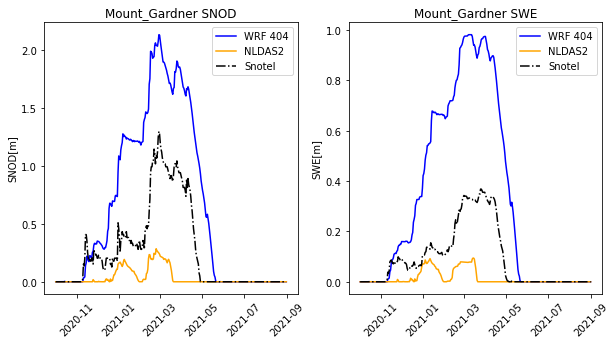

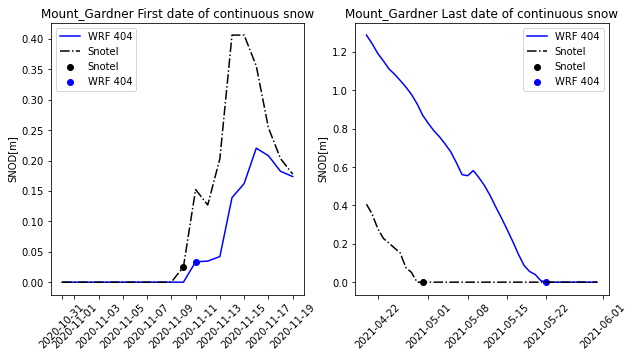

In [133]:
import os
import time
from IPython.display import clear_output

# output directory #
output_direc = 'snowmodel/snotel2/'
snotel_dir = f'snotel/data/WY{2019}/'

files = os.listdir(snotel_dir)

# wrf domain #
lat_domain_wrf=ds_404_domain.XLAT.values
lon_domain_wrf=ds_404_domain.XLONG.values


# ids domain #
lat_domain_ids=ds_ids_domain.XLAT.values
lon_domain_ids=ds_ids_domain.XLONG.values

# nldas domain #
lat_domain_nldas=ds_nldas_domain.XLAT.values
lon_domain_nldas=ds_nldas_domain.XLONG.values

# create timing #
t_ar = create_datetime(wrf_404_dict['tstart'],wrf_404_dict['toutput'],wrf_404_dict['timestep'])


missing_data = []

df_nldas = pd.DataFrame(columns=['snotel','latitude','longitude', 'elevation', 'vegetation','swe_avg_diff','swe_rmse','swe_l_inf_norm'])
df_wrf = pd.DataFrame(columns=['snotel', 'latitude','longitude','elevation', 'vegetation','swe_avg_diff','swe_rmse','swe_l_inf_norm'])
df_ids = pd.DataFrame(columns=['snotel', 'latitude','longitude','elevation', 'vegetation','swe_avg_diff','swe_rmse','swe_l_inf_norm'])

snotel_lat = []
snotel_lon = []
snotel_name = []
nldas_swed = []
nldas_snod = []
wrf_swed = []
wrf_snod = []
ids_swed = []
ids_snod = []

count = 0
for f in files:
    print(f)

    try:
        # if f in ['Muckamuck.nc']:
    # wrf #
        wrf_idx,wrf_idy,wrf_swed_rmse,wrf_snod_rmse,wrf_swed_avgdiff,wrf_snod_avgdiff,wrf_swed_lnorm,wrf_snod_lnorm,lat,lon,ds_wrf,snotel = sm_snotel_intersect(f,
                             lat_domain_wrf,lon_domain_wrf,wrf_404_dict,
                             output_direc,ds_404_domain.XLAT.shape,t_ar)
        wrf_maxsnow_idx,wrf_maxsnow_dt, wrf_snowoff_idx,wrf_snowoff_dt,wrf_firstsnow_idx,wrf_firstsnow_dt = snow_onset_dates(ds_wrf)
        # wrf_firstsnow_idx,wrf_firstsnow_dt = snow_onset_dates(ds_wrf)
        
        # ids #
        ids_idx,ids_idy,ids_swed_rmse,ids_snod_rmse,ids_swed_avgdiff,ids_snod_avgdiff,ids_swed_lnorm,ids_snod_lnorm,lat,lon,ds_ids,snotel = sm_snotel_intersect(f,
                     lat_domain_ids,lon_domain_ids,uw_wrf_dict,
                     output_direc,ds_ids_domain.XLAT.shape,t_ar)
        ids_maxsnow_idx,ids_maxsnow_dt, ids_snowoff_idx,ids_snowoff_dt,ids_firstsnow_idx,ids_firstsnow_dt = snow_onset_dates(ds_ids)
        # ids_firstsnow_idx,ids_firstsnow_dt = snow_onset_dates(ds_ids)
        
        # nldas #
        nldas_idx,nldas_idy,nldas_swed_rmse,nldas_snod_rmse,nldas_swed_avgdiff,nldas_snod_avgdiff,nldas_swed_lnorm,nldas_snod_lnorm,lat,lon,ds_nldas,snotel = sm_snotel_intersect(f,
             lat_domain_nldas,lon_domain_nldas,nldas_dict,
             output_direc,ds_nldas_domain.XLAT.shape,t_ar)
        
        nldas_maxsnow_idx,nldas_maxsnow_dt, nldas_snowoff_idx,nldas_snowoff_dt,nldas_firstsnow_idx,nldas_firstsnow_dt = snow_onset_dates(ds_nldas)
        # nldas_firstsnow_idx,nldas_firstsnow_dt = snow_onset_dates(ds_nldas)
        
        ## snotel ##
        snotel_maxsnow_idx,snotel_maxsnow_dt, snotel_snowoff_idx,snotel_snowoff_dt,snotel_firstsnow_idx,snotel_firstsnow_dt = snow_onset_dates(snotel)
        # snotel_firstsnow_idx,snotel_firstsnow_dt = snow_onset_dates(snotel)
        
        
        snotel_lat.append(lat)
        snotel_lon.append(lon)
        snotel_name.append(f[:-3])
        
        del_ = 10
        
        
        # ds concat #
        ds_concat = concat_datasets(ds_wrf,ds_ids,ds_nldas,snotel,output_direc,f)
        
        # peak wrf #
        wrf_peak_swe = float(ds_concat.conus_swe.max(skipna = True).values)
        wrf_peak_snod = float(ds_concat.conus_snod.max(skipna = True).values)
        # peak wrf #
        nldas_peak_swe = float(ds_concat.nldas_swe.max(skipna = True).values)
        nldas_peak_snod = float(ds_concat.nldas_snod.max(skipna = True).values)
        # peak snotel #
        snotel_peak_swe = float(ds_concat.snotel_swe.max(skipna = True).values)
        snotel_peak_snod = float(ds_concat.snotel_snod.max(skipna = True).values)
        
        # percent_diff #
        percent_diff_swe_wrf = (snotel_peak_swe - wrf_peak_swe) / snotel_peak_swe
        percent_diff_snod_wrf = (snotel_peak_snod - wrf_peak_snod) / snotel_peak_snod
        # percent_diff #
        percent_diff_swe_nldas = (snotel_peak_swe - nldas_peak_swe) / snotel_peak_swe
        percent_diff_snod_nldas = (snotel_peak_snod - nldas_peak_snod) / snotel_peak_snod
            
        fig,ax = plt.subplots(1,2,figsize = (10,5))
        ax[0].plot(ds_concat.Time,ds_concat.conus_snod,label = 'WRF 404',color = 'blue')
        # ax[0].plot(ds_concat.Time,ds_concat.uw_snod,label = 'IDS',color = 'red')
        ax[0].plot(ds_concat.Time,ds_concat.nldas_snod,label = 'NLDAS2',color = 'orange')
        ax[0].plot(ds_concat.Time,ds_concat.snotel_snod,'k-.',label = 'Snotel')
        ax[0].legend()
        ax[0].set_ylabel('SNOD[m]')
        ax[0].tick_params(axis='x', rotation=45)
        ax[0].set_title(f[:-3] + ' SNOD')
    
        ax[1].plot(ds_concat.Time,ds_concat.conus_swe,label = 'WRF 404',color = 'blue')
        # ax[1].plot(ds_concat.Time,ds_concat.uw_swe,label = 'IDS',color = 'red')
        ax[1].plot(ds_concat.Time,ds_concat.nldas_swe,label = 'NLDAS2',color = 'orange')
        ax[1].plot(ds_concat.Time,ds_concat.snotel_swe,'k-.',label = 'Snotel')
        ax[1].legend()
        ax[1].set_ylabel('SWE[m]')
        ax[1].tick_params(axis='x', rotation=45)
        ax[1].set_title(f[:-3] + ' SWE')
        plt.show()
        if wrf_firstsnow_idx < snotel_firstsnow_idx:
            min_ = wrf_firstsnow_idx - del_
            if min_ < 0:
                min_ = min_ + del_
            max_ = snotel_firstsnow_idx + del_
        else:
            min_ = snotel_firstsnow_idx - del_
            if min_ < 0:
                min_ = min_ + del_
            max_ = wrf_firstsnow_idx + del_
        fig,ax = plt.subplots(1,2,figsize = (10,5))
        ax[0].plot(ds_concat.Time[min_:max_],ds_concat.conus_snod[min_:max_],label = 'WRF 404',color = 'blue')
        ax[0].plot(ds_concat.Time[min_:max_],ds_concat.snotel_snod[min_:max_],'k-.',label = 'Snotel')
        ax[0].scatter(ds_concat.Time[snotel_firstsnow_idx],ds_concat.snotel_snod[snotel_firstsnow_idx],color = 'black',label = 'Snotel')
        ax[0].scatter(ds_concat.Time[wrf_firstsnow_idx+1],ds_concat.conus_snod[wrf_firstsnow_idx+1],color = 'blue',label = 'WRF 404')
        ax[0].legend()
        ax[0].set_ylabel('SNOD[m]')
        ax[0].tick_params(axis='x', rotation=45)
        ax[0].set_title(f[:-3] + ' First date of continuous snow')
        if wrf_snowoff_idx < snotel_snowoff_idx:
            min_ = wrf_snowoff_idx - del_
            max_ = snotel_snowoff_idx + del_
            max_var = 'SNOTEL'
        else:
            min_ = snotel_snowoff_idx - del_
            max_ = wrf_snowoff_idx + del_
            max_var = 'WRF 404'
        ax[1].plot(ds_concat.Time[min_:max_],ds_concat.conus_snod[min_:max_],label = 'WRF 404',color = 'blue')
        ax[1].plot(ds_concat.Time[min_:max_],ds_concat.snotel_snod[min_:max_],'k-.',label = 'Snotel')
        ax[1].scatter(ds_concat.Time[snotel_snowoff_idx],ds_concat.snotel_snod[snotel_snowoff_idx],color = 'black',label = 'Snotel')
        ax[1].scatter(ds_concat.Time[wrf_snowoff_idx],ds_concat.conus_snod[wrf_snowoff_idx],color = 'blue',label = 'WRF 404')
        ax[1].legend()
        ax[1].set_ylabel('SNOD[m]')
        ax[1].tick_params(axis='x', rotation=45)
        ax[1].set_title(f[:-3] + ' Last date of continuous snow')
        plt.show()
        # identify elevation and vegetation of snotel #
        elev = float(ds_nldas_domain.HGT[nldas_idx,nldas_idy].values)
        veg = int(ds_nldas_domain.VEG[nldas_idx,nldas_idy].values)
        nldas_dict_ = {'snotel':f[:-3], 'elevation':elev,'latitude':lat,'longitude':lon, 'vegetation':veg,'modelmax[SWE]':nldas_peak_swe,'snotelmax[SWE]':snotel_peak_swe,'snotel-model[SWE]':snotel_peak_swe-nldas_peak_swe,'% diff[SWE]':percent_diff_swe_nldas,
                       'modelmax[SNOD]':nldas_peak_snod,'snotelmax[SNOD]':snotel_peak_snod,'snotel-model[SNOD]':snotel_peak_snod-nldas_peak_snod,'% diff[SNOD]':percent_diff_snod_nldas,
                       'swe_avg_diff':(-1*nldas_swed_avgdiff),'swe_rmse':nldas_swed_rmse,'swe_l_inf_norm':nldas_swed_lnorm,
                      'snod_avg_diff':(-1*nldas_snod_avgdiff),'snod_rmse':nldas_snod_rmse,'snod_l_inf_norm':nldas_snod_lnorm,
                   'first_snod_dt':pd.to_datetime(nldas_firstsnow_dt),'first_snod_diff': int(snotel_firstsnow_idx-nldas_firstsnow_idx+1),
                  'max_snod_dt':pd.to_datetime(nldas_maxsnow_dt),'max_snod_diff':int(snotel_maxsnow_idx-nldas_maxsnow_idx),
                      'snowoff_snod_dt':pd.to_datetime(nldas_snowoff_dt),'snowoff_snod_diff':int(snotel_snowoff_idx-nldas_snowoff_idx)}
        
        wrf_dict_ = {'snotel':f[:-3], 'elevation':elev,'latitude':lat,'longitude':lon, 'vegetation':veg,'modelmax[SWE]':wrf_peak_swe,'snotelmax[SWE]':snotel_peak_swe,'snotel-model[SWE]':snotel_peak_swe-wrf_peak_swe,'% diff[SWE]':percent_diff_swe_wrf,
                       'modelmax[SNOD]':wrf_peak_snod,'snotelmax[SNOD]':snotel_peak_snod,'snotel-model[SNOD]':snotel_peak_snod-wrf_peak_snod,'% diff[SNOD]':percent_diff_snod_wrf,
                     'swe_avg_diff':(-1*wrf_swed_avgdiff),'swe_rmse':wrf_swed_rmse,'swe_l_inf_norm':wrf_swed_lnorm,
                    'snod_avg_diff':(-1*wrf_snod_avgdiff),'snod_rmse':wrf_snod_rmse,'snod_l_inf_norm':wrf_snod_lnorm,
                     'first_snod_dt':pd.to_datetime(wrf_firstsnow_dt),'first_snod_diff':int(snotel_firstsnow_idx-wrf_firstsnow_idx+1),
                      'max_snod_dt':pd.to_datetime(wrf_maxsnow_dt),'max_snod_diff':int(snotel_maxsnow_idx-wrf_maxsnow_idx),
                  'snowoff_snod_dt':pd.to_datetime(wrf_snowoff_dt),'snowoff_snod_diff':int(snotel_snowoff_idx-wrf_snowoff_idx)}
        
        ids_dict_ = {'snotel':f[:-3], 'elevation':elev,'latitude':lat,'longitude':lon, 'vegetation':veg,
                     'swe_avg_diff':(-1*ids_swed_avgdiff),'swe_rmse':ids_swed_rmse,'swe_l_inf_norm':ids_swed_lnorm,
                     'snod_avg_diff':(-1*ids_snod_avgdiff),'snod_rmse':ids_snod_rmse,'snod_l_inf_norm':ids_snod_lnorm,
                     'first_snod_dt':pd.to_datetime(ids_firstsnow_dt),'first_snod_diff':int(snotel_firstsnow_idx-ids_firstsnow_idx+1),
                      'max_snod_dt':pd.to_datetime(ids_maxsnow_dt),'max_snod_diff':int(snotel_maxsnow_idx-ids_maxsnow_idx),
                      'snowoff_snod_dt':pd.to_datetime(ids_snowoff_dt),'snowoff_snod_diff':int(snotel_snowoff_idx-ids_snowoff_idx)}
            
        #          # append rows #
        df_nldas = df_nldas.append(nldas_dict_, ignore_index = True)
        df_wrf = df_wrf.append(wrf_dict_, ignore_index = True)
        df_ids = df_ids.append(ids_dict_, ignore_index = True)
        
        # time.sleep(5)
        # break
        # input('')
        clear_output(wait=True)
        count += 1
            
                
    except:
        print('Could not process '+ f)
        missing_data.append(f)
            
            
            
    count += 1
    
        
    
    
    
    # sm_snotel_intersect(f,fname_sm_grid,wrf_404_inputs,output_dir)

In [ ]:
nldas_peak_snod

In [ ]:
snotel_firstsnow_dt

In [ ]:
snotel.SNOD.values

In [ ]:
# snotel_lat_arr = np.array(snotel_lat)
# snotel_lon_arr = np.array(snotel_lon)
# snotel_name_arr = np.array(snotel_name)
# nldas_swed_arr = np.array(nldas_swed)
# nldas_snod_arr = np.array(nldas_snod)
# wrf_swed_arr = np.array(wrf_swed)
# wrf_snod_arr = np.array(wrf_snod)
# ids_swed_arr = np.array(ids_swed)
# ids_snod_arr = np.array(ids_snod)

# nldas_swed_arr = nldas_swed_arr.reshape(t_ar.shape,nldas_swed_arr.shape)
# nldas_snod_arr = nldas_snod_arr.reshape(t_ar.shape,nldas_snod_arr.shape)
# wrf_swed_arr = wrf_swed_arr.reshape(t_ar.shape,wrf_swed_arr.shape)
# wrf_snod_arr = wrf_snod_arr.reshape(t_ar.shape,wrf_snod_arr.shape)
# ids_swed_arr = ids_swed_arr.reshape(t_ar.shape,ids_swed_arr.shape)
# ids_snod_arr = ids_snod_arr.reshape(t_ar.shape,ids_snod_arr.shape)


# print(snotel_lat_arr.shape)
# print(snotel_lon_arr.shape)
# print(snotel_name_arr.shape)
# print(nldas_swed_arr.shape)
# print(nldas_snod_arr.shape)
# print(wrf_swed_arr.shape)
# print(wrf_snod_arr.shape)
# print(ids_swed_arr.shape)
# print(ids_snod_arr.shape)


# ds = xr.Dataset(
#             data_vars = dict(
#                 snotel_swe = (["Time"],snotel_swe),
#                 snotel_snod = (["Time"],snotel_snod),
#                 nldas_swe = (["Time"],nldas_swe),
#                 nldas_snod = (["Time"],nldas_snod),
#                 conus_swe = (["Time"],wrf_swe),
#                 conus_snod = (["Time"],wrf_snod),
#                 uw_swe = (["Time"],ids_swe),
#                 uw_snod = (["Time"],ids_snod),
#             ),
#             coords={"Time": ("Time",t_ar),
#                     "XLAT": (("south_north"),snotel_lat_arr),
#                     "XLONG": (("east_west"),snotel_lon_arr),})

In [ ]:
# difference in peak swe #
# percent difference in peak swe #
# - 120.6 #
df_nldas[['snotel','latitude','longitude','modelmax[SWE]','snotelmax[SWE]','snotel-model[SWE]','% diff[SWE]','modelmax[SNOD]','snotelmax[SNOD]','snotel-model[SNOD]','% diff[SNOD]']].sort_values(by='longitude',ascending = False)

In [134]:
df_wrf[['snotel','latitude','longitude','modelmax[SWE]','snotelmax[SWE]','snotel-model[SWE]','% diff[SWE]','modelmax[SNOD]','snotelmax[SNOD]','snotel-model[SNOD]','% diff[SNOD]']].sort_values(by='longitude',ascending = False)

,snotel,latitude,longitude,modelmax[SWE],snotelmax[SWE],snotel-model[SWE],% diff[SWE],modelmax[SNOD],snotelmax[SNOD],snotel-model[SNOD],% diff[SNOD]
16,Quartz_Peak,47.879268646240234,-117.0893783569336,0.465304,0.54356,0.078256,0.143969,1.133194,1.6764,0.543206,0.324031
36,Bunchgrass_Mdw,48.6868782043457,-117.17633056640625,0.466925,0.59182,0.124895,0.211035,1.054463,1.8796,0.825137,0.438996
26,Gold_Mountain,48.18933868408203,-118.45590209960938,0.315205,0.30988,-0.005325,-0.017182,0.781101,0.9906,0.209499,0.211487
19,Gold_Axe_Camp,48.95159912109375,-118.98639678955078,0.218281,0.33528,0.116999,0.348959,0.661709,1.1684,0.506691,0.433662
17,Moses_Mtn,48.361629486083984,-119.08158874511719,0.416006,0.43434,0.018334,0.042212,1.213942,1.2446,0.030658,0.024633
9,Salmon_Meadows,48.655181884765625,-119.83830261230469,0.218628,0.29210,0.073472,0.251530,0.605651,1.2446,0.638949,0.513377
30,Muckamuck,48.58525848388672,-119.86624145507812,0.375237,0.27432,-0.100917,-0.367879,1.034848,1.0922,0.057352,0.052511
37,Trough,47.233280181884766,-120.29412078857422,0.584842,0.29718,-0.287662,-0.967972,1.398869,1.0414,-0.357469,-0.343258
22,Upper_Wheeler,47.28733825683594,-120.37014770507812,0.356417,0.26670,-0.089717,-0.336397,0.960788,1.0668,0.106012,0.099374
18,Grouse_Camp,47.281070709228516,-120.48770904541016,0.806531,0.53594,-0.270591,-0.504890,1.696625,1.4224,-0.274225,-0.192791


In [ ]:
df_wrf

In [ ]:
df_ids

In [ ]:
df_wrf[['snod_avg_diff','snod_rmse','snod_l_inf_norm','first_snod_diff','max_snod_diff','snowoff_snod_diff']].median()

In [ ]:
df_nldas[['snod_avg_diff','snod_rmse','snod_l_inf_norm','first_snod_diff','max_snod_diff','snowoff_snod_diff']].median()

In [ ]:
df_ids[['snod_avg_diff','snod_rmse','snod_l_inf_norm','first_snod_diff','max_snod_diff','snowoff_snod_diff']].median()

In [135]:
# convert to geopandas #
gdf_wrf = gpd.GeoDataFrame(
    df_wrf, geometry=gpd.points_from_xy(df_wrf.longitude, df_wrf.latitude))

gdf_nldas = gpd.GeoDataFrame(
    df_nldas, geometry=gpd.points_from_xy(df_nldas.longitude, df_nldas.latitude))

gdf_ids = gpd.GeoDataFrame(
    df_nldas, geometry=gpd.points_from_xy(df_ids.longitude, df_ids.latitude))


In [ ]:
gdf_wrf.swe_avg_diff.min()

In [ ]:
fig,ax = plt.subplots(dpi = 200)
df_wrf.hist('swe_avg_diff',bins = 10,ax=ax,label = 'WRF 404',color = 'blue')
df_nldas.hist('swe_avg_diff',bins = 10,ax=ax,label = 'NLDAS2',color = 'orange')
df_ids.hist('swe_avg_diff',bins = 10,ax=ax,label = 'IDS',color = 'red')
plt.xlabel('Avg. SWE Difference [m]')
plt.ylabel('Count')
ax.grid(False)
plt.legend()
plt.title('Histogram of Average SWE Difference')

In [ ]:
fig,ax = plt.subplots(dpi = 200)
df_wrf.plot(ax=ax,kind = 'scatter',x = 'elevation',y = 'swe_avg_diff',label = 'WRF 404',color = 'blue')
df_nldas.plot(ax=ax,kind = 'scatter',x = 'elevation',y = 'swe_avg_diff',label = 'NLDAS2',color = 'orange')
plt.xlabel('Elevation [m]')
plt.ylabel('Avg. SWE Difference [m]')
plt.title('SWE Difference vs. Elevation')
# gdf_nldas.hist('swe_avg_diff',bins = 10,ax=ax)

In [ ]:
# vegetation #
fig,ax = plt.subplots(dpi = 200)
df_wrf.plot(ax=ax,kind = 'scatter',x = 'vegetation',y = 'swe_avg_diff',label = 'WRF 404',color = 'blue')
df_nldas.plot(ax=ax,kind = 'scatter',x = 'vegetation',y = 'swe_avg_diff',label = 'NLDAS2',color = 'orange')
plt.xlabel('Vegetation Type')
plt.ylabel('Avg. SWE Difference [m]')
plt.title('SWE Difference vs. Vegetation')

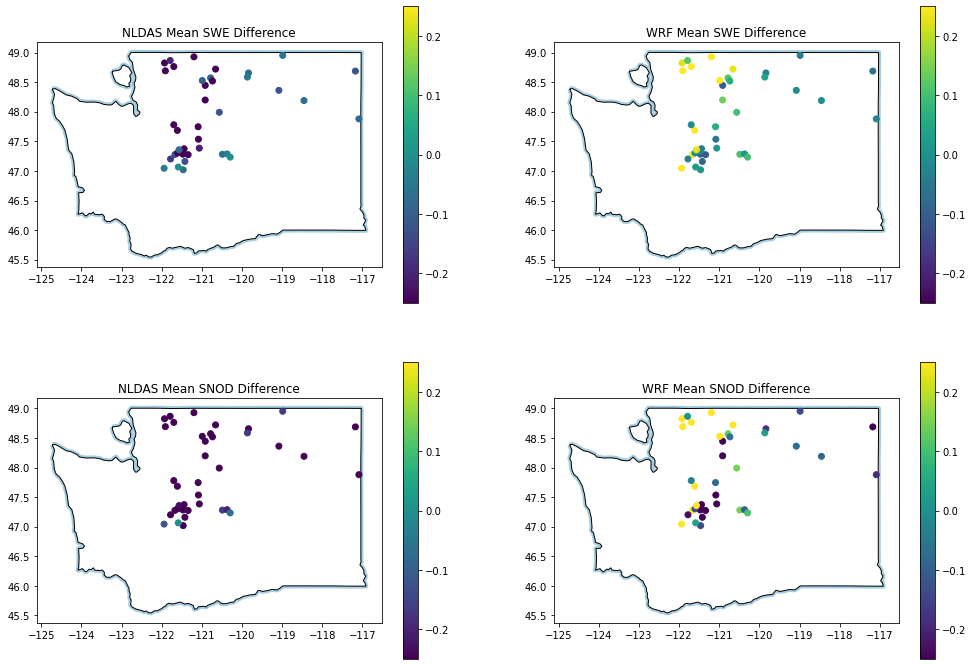

In [164]:
"""
    SPATIAL PLOT OF MEAN SWE DIFFERENCE
"""

vmin, vmax = -0.25, 0.25

fig,ax = plt.subplots(2,2,figsize = (17,12))


boundary_gpd.plot(ax = ax[0][0],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[0][0],color = 'white', edgecolor = 'k')
s1 = ax[0][0].scatter(gdf_nldas.longitude,gdf_nldas.latitude,c = gdf_nldas.swe_avg_diff,vmin = vmin,vmax = vmax)
ax[0][0].set_title(('NLDAS Mean SWE Difference'))
plt.colorbar(s1,ax = ax[0][0])


boundary_gpd.plot(ax = ax[0][1],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[0][1],color = 'white', edgecolor = 'k')
s2 = ax[0][1].scatter(gdf_wrf.longitude,gdf_wrf.latitude,c = gdf_wrf.swe_avg_diff,vmin = vmin,vmax = vmax)
ax[0][1].set_title(('WRF Mean SWE Difference'))
plt.colorbar(s2,ax = ax[0][1])
# plt.show()

boundary_gpd.plot(ax = ax[1][0],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[1][0],color = 'white', edgecolor = 'k')
s3 = ax[1][0].scatter(gdf_nldas.longitude,gdf_nldas.latitude,c = gdf_nldas.snod_avg_diff,vmin = vmin,vmax = vmax)
ax[1][0].set_title(('NLDAS Mean SNOD Difference'))
plt.colorbar(s3,ax = ax[1][0])


boundary_gpd.plot(ax = ax[1][1],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[1][1],color = 'white', edgecolor = 'k')
s4 = ax[1][1].scatter(gdf_wrf.longitude,gdf_wrf.latitude,c = gdf_wrf.snod_avg_diff,vmin = vmin,vmax = vmax)
ax[1][1].set_title(('WRF Mean SNOD Difference'))
plt.colorbar(s4, ax = ax[1][1])
plt.show()


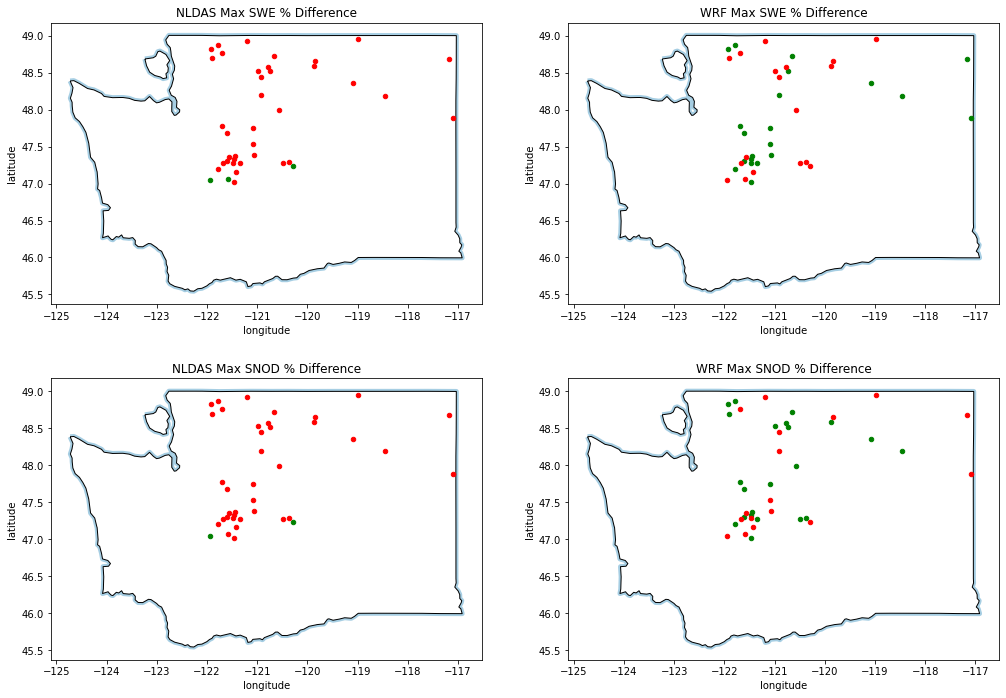

In [163]:
"""
    SPATIAL PLOT OF MAX SWE % DIFFERENCE
        - threshold of 0.25
"""

fig,ax = plt.subplots(2,2,figsize = (17,12))

## NLDAS % DIFF SWE ##
boundary_gpd.plot(ax = ax[0][0],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[0][0],color = 'white', edgecolor = 'k')
gdf_nldas[abs(gdf_nldas['% diff[SWE]']) <= 0.25].plot(ax = ax[0][0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'green')
gdf_nldas[abs(gdf_nldas['% diff[SWE]']) > 0.25].plot(ax = ax[0][0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'red')
ax[0][0].set_title(('NLDAS Max SWE % Difference'))

## WRF % DIFF SWE ##
boundary_gpd.plot(ax = ax[0][1],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[0][1],color = 'white', edgecolor = 'k')
gdf_wrf[abs(gdf_wrf['% diff[SWE]']) <= 0.25].plot(ax = ax[0][1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'green')
gdf_wrf[abs(gdf_wrf['% diff[SWE]']) > 0.25].plot(ax = ax[0][1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'red')
ax[0][1].set_title(('WRF Max SWE % Difference'))

## NLDAS % DIFF SNOD ##
boundary_gpd.plot(ax = ax[1][0],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[1][0],color = 'white', edgecolor = 'k')
gdf_nldas[abs(gdf_nldas['% diff[SNOD]']) <= 0.25].plot(ax = ax[1][0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'green')
gdf_nldas[abs(gdf_nldas['% diff[SNOD]']) > 0.25].plot(ax = ax[1][0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'red')
ax[1][0].set_title(('NLDAS Max SNOD % Difference'))

## WRF % DIFF SNOD ##
boundary_gpd.plot(ax = ax[1][1],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[1][1],color = 'white', edgecolor = 'k')
gdf_wrf[abs(gdf_wrf['% diff[SNOD]']) <= 0.25].plot(ax = ax[1][1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'green')
gdf_wrf[abs(gdf_wrf['% diff[SNOD]']) > 0.25].plot(ax = ax[1][1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'red')
ax[1][1].set_title(('WRF Max SNOD % Difference'))
plt.show()

Text(0.5, 1.0, 'WRF Max % Difference w/in 25%')

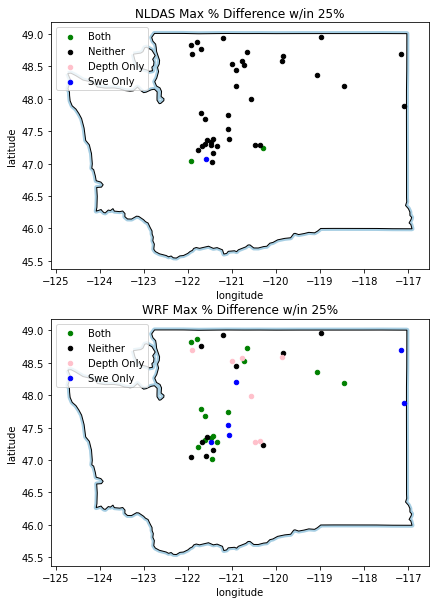

In [158]:
"""
    SPATIAL PLOT OF MAX SWE % DIFFERENCE
        - threshold of 0.25
"""

fig,ax = plt.subplots(2,1,figsize = (7,10))

## NLDAS % DIFF SWE ##
boundary_gpd.plot(ax = ax[0],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[0],color = 'white', edgecolor = 'k')
gdf_nldas[(abs(gdf_nldas['% diff[SWE]']) <= 0.25) & (abs(gdf_nldas['% diff[SNOD]']) <= 0.25)].plot(ax = ax[0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'green',label = 'Both')
gdf_nldas[(abs(gdf_nldas['% diff[SWE]']) > 0.25) & (abs(gdf_nldas['% diff[SNOD]']) > 0.25)].plot(ax = ax[0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'black',label = 'Neither')
gdf_nldas[(abs(gdf_nldas['% diff[SWE]']) > 0.25) & (abs(gdf_nldas['% diff[SNOD]']) <= 0.25)].plot(ax = ax[0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'pink',label = 'Depth Only')
gdf_nldas[(abs(gdf_nldas['% diff[SWE]']) <= 0.25) & (abs(gdf_nldas['% diff[SNOD]']) > 0.25)].plot(ax = ax[0],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'blue',label = 'Swe Only')
ax[0].set_title(('NLDAS Max % Difference w/in 25%'))
# ax[0].set_legend()

## WRF % DIFF SWE ##
boundary_gpd.plot(ax = ax[1],color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax[1],color = 'white', edgecolor = 'k')
gdf_wrf[(abs(gdf_wrf['% diff[SWE]']) <= 0.25) & (abs(gdf_wrf['% diff[SNOD]']) <= 0.25)].plot(ax = ax[1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'green',label = 'Both')
gdf_wrf[(abs(gdf_wrf['% diff[SWE]']) > 0.25) & (abs(gdf_wrf['% diff[SNOD]']) > 0.25)].plot(ax = ax[1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'black',label = 'Neither')
gdf_wrf[(abs(gdf_wrf['% diff[SWE]']) > 0.25) & (abs(gdf_wrf['% diff[SNOD]']) <= 0.25)].plot(ax = ax[1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'pink',label = 'Depth Only')
gdf_wrf[(abs(gdf_wrf['% diff[SWE]']) <= 0.25) & (abs(gdf_wrf['% diff[SNOD]']) > 0.25)].plot(ax = ax[1],kind = 'scatter',x = 'longitude',y = 'latitude',color = 'blue',label = 'Swe Only')
ax[1].set_title(('WRF Max % Difference w/in 25%'))


In [ ]:
vmin, vmax = -0.25, 0.25

fig,ax = plt.subplots(dpi = 200)


boundary_gpd.plot(ax = ax,color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = 'k')
plt.scatter(gdf_nldas.longitude,gdf_nldas.latitude,c = gdf_nldas.swe_avg_diff,vmin = vmin,vmax = vmax)#,vmin = vmin,vmax = vmax)
plt.title(('NLDAS Mean SWE Difference'))
plt.colorbar()
plt.show()

In [ ]:
vmin, vmax = -0.3, 0.3

fig,ax = plt.subplots(dpi = 200)


boundary_gpd.plot(ax = ax,color = 'white', edgecolor = '#a6cee3',linewidth = 5,legend = False)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = 'k',legend = False)
s1 = ax.scatter(gdf_nldas.longitude,gdf_nldas.latitude,c = gdf_nldas.swe_avg_diff,vmin = vmin,vmax = vmax)
cb = plt.colorbar(s1)
plt.title('NLDAS2[snowfrac_3] - Snotel\nSWE Mean Difference')
plt.show()

fig,ax = plt.subplots(dpi = 200)


boundary_gpd.plot(ax = ax,color = 'white', edgecolor = '#a6cee3',linewidth = 5,legend = False)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = 'k',legend = False)
s1 = ax.scatter(gdf_wrf.longitude,gdf_wrf.latitude,c = gdf_wrf.swe_avg_diff,vmin = vmin,vmax = vmax)
plt.title('WRF CONUS [snowfrac_5] - Snotel\nSWE Mean Difference')
cb = plt.colorbar(s1)
plt.show()



In [ ]:
import os
path = 'snotel/data/'
vmin, vmax = -0.25, 0.25

f = 'Thunder_Basin.nc'



# snowmodel output #
ds_sm = xr.load_dataset('snowmodel/snotel/'+f)
# snotel output #
ds_snotel = xr.load_dataset('snotel/data/' +f)

fig,ax = plt.subplots(dpi = 200)

plt.plot(ds_sm.Time,ds_sm.SWED_WRF_404,label = 'WRF 404',color = 'blue')
plt.plot(ds_sm.Time,ds_sm.SWED_NLDAS,label = 'NLDAS2',color = 'orange')
plt.plot(ds_snotel.Time,ds_snotel.SWED,'k-.',label = 'Snotel')
plt.legend()
plt.ylabel('SWE[m]')
plt.tick_params(axis='x', rotation=45)
plt.title(f[:-3] + ' SWE')
plt.show()


fig,ax = plt.subplots(dpi = 200)

boundary_gpd.plot(ax = ax,color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = 'k')
# gdf_wrf.plot(ax=ax,c = gdf_wrf.swe_avg_diff,vmin = vmin,vmax = vmax,legend = True)
ax.scatter(ds_snotel.XLONG,ds_snotel.XLAT,color = 'red')

# plt.plot(ds_sm.Time,ds_sm.SWED_WRF_404,label = 'WRF 404',color = 'blue')
# plt.plot(ds_sm.Time,ds_sm.SWED_NLDAS,label = 'NLDAS2',color = 'orange')
# plt.plot(ds_snotel.Time,ds_snotel.SWED,'k-.',label = 'Snotel')
# plt.legend()
# plt.ylabel('SWE[m]')
# plt.tick_params(axis='x', rotation=45)
# plt.title(f[:-3] + ' SWE')
# plt.show()

In [ ]:
df_wrf[(df_wrf['snotel']=='Stevens_Pass')]# & (gdf_wrf['longitude'] < -122.5)]

In [ ]:
df_nldas[(df_nldas['snotel']=='Stevens_Pass')]# & (gdf_wrf['longitude'] < -122.5)]

In [ ]:
df_wrf[['swe_avg_diff','swe_rmse','swe_l_inf_norm']].mean()

In [ ]:
df_wrf[((df_wrf['swe_avg_diff'] > 0.0) & (df_wrf['snod_avg_diff'] < 0.0))]

In [ ]:
df_wrf[((df_wrf['snod_avg_diff'] > 0.0))]

In [ ]:
df_wrf[((df_wrf['snod_rmse'] > 0.15))]

In [ ]:
df_wrf[((df_wrf['swe_rmse'] > 0.15))]

In [ ]:
df_wrf.groupby('vegetation')['swe_avg_diff'].mean().plot(kind = 'bar')

In [ ]:
df_wrf[((df_wrf['swe_rmse'] < 0.15) & (df_wrf['swe_l_inf_norm'] < 0.25))].groupby('vegetation')['swe_rmse'].count()

In [ ]:
df_wrf.groupby('vegetation')['swe_avg_diff'].hist()

In [ ]:
df_nldas[['swe_avg_diff','swe_rmse','swe_l_inf_norm']].mean()

In [ ]:
df_ids[['swe_avg_diff','swe_rmse','swe_l_inf_norm']].mean()

In [ ]:
ds_skoo = xr.load_dataset('snowmodel/snotel/Skookum_Creek.nc')
ds_skoo

In [ ]:
ds_snotel = xr.load_dataset('snotel/data/Skookum_Creek.nc')
ds_snotel
fig,ax = plt.subplots()
plt.plot(ds_skoo.Time,ds_skoo.SNOD_WRF_404)
plt.plot(ds_skoo.Time,ds_skoo.SNOD_NLDAS_404)
plt.plot(ds_snotel.Time,ds_snotel.SNOD,color = 'black')


In [ ]:
lat_min = 47.680
lat_max = 47.690
lon_min = -121.615
lon_max = -121.605
ds_snotel = xr.load_dataset('snotel/data/Skookum_Creek.nc')
ds_snotel

fig,ax = plt.subplots(dpi=200)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = 'k')
plt.scatter(ds_snotel.XLONG,ds_snotel.XLAT,color = 'green')
plt.scatter(ds_404_domain.XLONG[6321,4326],ds_404_domain.XLAT[6321,4326],color = 'red')
plt.scatter(ds_nldas_domain.XLONG[3468,3438],ds_nldas_domain.XLAT[3468,3438],color = 'blue')
plt.ylim(lat_min,lat_max)
plt.xlim(lon_min,lon_max)

fig,ax = plt.subplots(dpi=200)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = '#a6cee3',linewidth = 5)
boundary_gpd.plot(ax = ax,color = 'white', edgecolor = 'k')
plt.pcolormesh(ds_404_domain.XLONG,ds_404_domain.XLAT,ds_404_domain.HGT)
plt.scatter(ds_snotel.XLONG,ds_snotel.XLAT,color = 'green')
plt.scatter(ds_404_domain.XLONG[6321,4326],ds_404_domain.XLAT[6321,4326],color = 'red')
plt.scatter(ds_nldas_domain.XLONG[3468,3438],ds_nldas_domain.XLAT[3468,3438],color = 'blue')

In [ ]:
snotel = 'Alpine_Meadows.nc'
sm_grid = 'wash_wrf_404_ctrl.nc'
output_direc = 'snowmodel/snotel/'

sm_snotel_intersect(snotel,sm_grid,wrf_404_dict,output_direc)